# Introduction
This code deals with the 2D cohesive fracture simulation of a uniaxial tensile test on a plain concrete specimen. An intrinsic cohesive zone model is adopted, where the solid finite elements are assumed to be linear elastic while zero-thickness joint elements whose behavior is characterized by nonlinear traction-separation laws are considered along all internal facets of the mesh. For this purpose, a Discontinuous Galerkin interpolation of the displacement field is used. The implementation is done with Firedrake, an automated system for finite element method solution, in Google Colab.

In [ ]:
# make plots appear in the notebook
%matplotlib inline 

# import necessary Python libraries
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# access Google Drive from Colab
from google.colab import drive
drive.mount('/content/drive')

# load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake
from firedrake import *

In [ ]:
# create an output directory and make it the current one 
import os
!mkdir out_files
os.chdir('out_files')

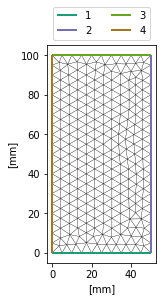

In [ ]:
# specimen geometry: width, height = 50, 100 [mm]
# load the mesh generated with Gmsh
mesh = Mesh('/content/drive/My Drive/Colab Notebooks/rectangle_coarse.msh')

# plot the mesh
fig, axes = plt.subplots()
triplot(mesh, axes=axes, interior_kw={'linewidth': 0.2}, boundary_kw={'linewidth': 2})
axes.set(xlabel='[mm]', ylabel='[mm]')
axes.set_aspect("equal")
axes.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2);

# Implementation
2D linear (constant strain triangle) elements are used. "DG" (Discontinuous Galerkin) spaces are defined for the displacement (2-dimensional vector) and the stress (3-dimensional vector), while scalar quantities which live only on the mesh facets (i.e., internal variables of the traction-separation laws) are represented using a "HDiv Trace" (also known as Discontinuous Lagrange Trace) space. The components in the stress vector are placed in the order: [$\sigma_{xx}$, $\sigma_{yy}$, $\tau_{xy}$]. Note that the facet functions are required to be restricted when used in forms, hence the `avg()` function and `('+')` or `('-')` are used here for the restriction purpose.

In [ ]:
## define FE function spaces and functions ##
# DG: scalar discontinuous Lagrange finite elements (discontinuous piecewise polynomial functions)
# HDiv Trace: discontinuous Lagrange trace elements (polynomials living on the mesh facets which are discontinuous at the vertices)

V = VectorFunctionSpace(mesh, "DG", 1) # for discontinuous displacement vector (u)
W = VectorFunctionSpace(mesh, "DG", 1, dim=3) # for discontinuous stress tensor (sig)
S = FunctionSpace(mesh, "HDiv Trace", 0) # for facet-based internal variables (dmax_n, dmax_t, gmax, flag)

u = Function(V, name="Displacement [mm]")
v = TestFunction(V)
sig = Function(W, name="Stress [MPa]")
dmax_n  = Function(S, name="Maximum normal opening [mm]")
dmax_t  = Function(S, name="Maximum tangential opening [mm]")
gmax = Function(S, name="Maximum effective opening [-]")
flag = Function(S, name="Joint state flag") # 1: active; 0: failed

dS = dS(degree=2) # interior facet integration measure
n = FacetNormal(mesh)
n_ , t_= n('-'), perp(n('-')) # restricted facet unit normal/tangential vector

In [ ]:
def facet_project(v, V):
    ''' 
    Project an expression 'v' onto a facet-based function space 'V'.
    If 'v' is a dictionary of the kind {region_1: value_1, region_2: value_2, ...}, then project 
    different expressions (value_i) on subdomains with corresponding facet markers (region_i).
    The default solver parameters apply conjugate gradients as an iterative linear solver, 
    with successive over-relaxation as a preconditioner. 
    '''
    v_, dv = TestFunction(V), TrialFunction(V)
    a = inner(avg(v_), avg(dv))*dS
    if isinstance(v, dict):
        L = sum([inner(avg(v_), val)*dS(reg) for (reg, val) in v.items()])
    else:
        L = inner(avg(v_), v)*dS
    u = Function(V)
    solve(a==L, u, solver_parameters={'ksp_type': 'cg', 'pc_type': 'jacobi'})
    return u

In [ ]:
# elastic parameters
E = Constant(30e3) # Young's modulus [MPa]
nu = Constant(0.2) # Poisson's ratio

# Lame parameters
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# strain tensor
def epsilon(u_):
    return sym(grad(u_)) # = 0.5*(grad(u_)+grad(u_).T)

# elastic stress-strain relation
def sigma(u_):
    I = Identity(u_.geometric_dimension()) # identity tensor
    return lmbda*tr(epsilon(u_))*I+2*mu*epsilon(u_)

In [ ]:
## define traction-separation laws ##

# strength parameters
sig0 = Constant(3) # uniaxial tensile strength [MPa]
c  = Constant(3) # internal cohesion [MPa]
phi = Constant(np.deg2rad(35)) # internal friction angle [degree] 

# fracture parameters
Gf1 = Constant(36e-3) # Mode I initial fracture energy [N/mm]
GF1 = 2.5*Gf1 # Mode I total fracture energy 
Gf2, GF2 = 4*Gf1, 4*GF1 # Mode II initial/total fracture energy

# quantities for defining bilinear mode I traction-separation law in the normal direction
pen = E # penalty stiffness
f0_n = sig0 # peak normal traction
d0_n = f0_n/pen # normal opening displacement corresponding to the peak traction
dk_n = Constant(0.016) # normal opening displacement corresponding to the kink point [mm]
k = 1-dk_n*f0_n/2/Gf1
fk_n = k*f0_n # normal traction corresponding to the kink point
df_n = 2*(GF1-(1-k)*Gf1)/fk_n # normal opening displacement corresponding to null traction
s1_n = (fk_n-f0_n)/(dk_n-d0_n) # slope of the first softening branch
s2_n = -fk_n/(df_n-dk_n) # slope of the second softening branch

# quantities for defining bilinear mode II traction-separation law in the tangential direction
f0_t = c # peak tangential traction (without frictional contribution)
d0_t = f0_t/pen # tangential opening displacement corresponding to the peak traction
fk_t = k*f0_t # tangential traction corresponding to the kink point
dk_t = 2*Gf2*(1-k)/f0_t # tangential opening displacement corresponding to the kink point
df_t = 2*(GF2-(1-k)*Gf2)/fk_t # tangential opening displacement corresponding to null traction
s1_t = (fk_t-f0_t)/(dk_t-d0_t) # slope of the first softening branch
s2_t = -fk_t/(df_t-dk_t) # slope of the second softening branch

# normal opening displacement
def d_n(u_):
    return dot(jump(u_), n_)

# tangential opening displacement
def d_t(u_):
    return dot(jump(u_), t_)

# effective opening 
def g(u_):
    return sqrt((pos(d_n(u_))/df_n)**2+(d_t(u_)/df_t)**2)

pos = lambda x: (x+abs(x))/2 # take the positive part of x, i.e., return x if x>0 and return 0 if x<=0

# virgin-loading definition of the traction-separation laws
def Tn_virgin(d_n): # mode I
    return conditional(d_n<=d0_n, pen*d_n, conditional(d_n<=dk_n, f0_n+s1_n*(d_n-d0_n), fk_n+s2_n*(d_n-dk_n)))                                                                                                                                       
def Tt_virgin(d_t): # mode II
    return conditional(abs(d_t)<=d0_t, pen*d_t, 
                                  sign(d_t)*(conditional(abs(d_t)<=dk_t, f0_t+s1_t*(abs(d_t)-d0_t), fk_t+s2_t*(abs(d_t)-dk_t))+pen*pos(-d_n(u))*tan(phi)))          

# unloading/reloding definition of the traction-separation laws
def Tn_ur(d_n, dmax): # mode I
    return conditional(dmax<=d0_n, pen*d_n, Tn_virgin(dmax)/dmax*d_n) 
def Tt_ur(d_t, dmax): # mode II
    return conditional(dmax<=d0_t, pen*d_t, Tt_virgin(dmax)/dmax*d_t)

# complete definition of the traction-separation laws
def Tn(d_n, dmax): # mode I
    return conditional(d_n>=dmax, Tn_virgin(d_n), Tn_ur(d_n, dmax))
def Tt(d_t, dmax): # mode II
    return conditional(abs(d_t)>=dmax, Tt_virgin(d_t), Tt_ur(d_t, dmax))

flag.assign(facet_project(1, S)) # initialize the state of all the joint elements to be active along the interior facets
T = (Tn(d_n(u), avg(dmax_n))*n_+Tt(d_t(u), avg(dmax_t))*t_)*avg(flag) # total traction vector

In [ ]:
# boundary conditions: displacement control on the bottom (marked 1) & top (marked 3) boundaries
m = Constant(0) # load multiplier for incremental loading
top_u, bottom_u = as_vector([0, 0.1]), as_vector([0, -0.1]) # imposed total displacement at top/bottom [mm]
# weak form of displacement-controlled loading at top and bottom
top_bc = pen*dot(v, m*top_u-u)*ds(3)
bottom_bc = pen*dot(v, m*bottom_u-u)*ds(1)

F_ext = top_bc+bottom_bc # external virtual work
F = inner(sigma(u), epsilon(v))*dx+inner(T, jump(v))*dS - F_ext # residual form of the variational problem

# create rigid body modes
x, y = SpatialCoordinate(mesh)
b0 = Function(V)
b1 = Function(V)
b2 = Function(V)
b0.interpolate(Constant([1, 0])) # rigid-body horizontal translation
b1.interpolate(Constant([0, 1])) # rigid-body vertical translation
b2.interpolate(as_vector([-y, x])) # rigid-body in-plane rotation
nullmodes = VectorSpaceBasis([b0, b1, b2])
nullmodes.orthonormalize()

# define the nonlinear problem and set the solver
problem = NonlinearVariationalProblem(F, u)
solver_parameters = {"ksp_type": "fgmres", "pc_type": "ilu"}
solver = NonlinearVariationalSolver(problem, solver_parameters=solver_parameters, nullspace=nullmodes)

In [ ]:
# represent a 2D tensor as a 3-dimensional vector
def vector_2D(X):
    return as_vector([X[0,0], X[1,1], X[0,1]])

# create output file
outfile = File("uts_czm_pc.pvd")
outfile.write(u, sig, time=0)
freq = 100 # output frequency (every n increments)

# set up incremental loading loop
Nincr = 10000 # number of loading increments
steps = np.linspace(0, 1, Nincr+1) # pseudo-time (load) steps

RF = [0] # vertical reaction force at top [N/mm]
sigy = [0] # vertical stress at top midpoint [MPa]
disp = [0] # vertical displacement at top midpoint [mm]

for (i, t) in enumerate(steps[1:]):
    print("Increment:", i+1)
    m.assign(t) # increase the load multiplier step by step
    solver.solve() # solve the nonlinear equation for u
    # once convergent solution is obtained for the current load increment:
    sig.assign(project(vector_2D(sigma(u)), W)) # update stress
    dn_, dt_, g_ = facet_project(d_n(u), S), facet_project(d_t(u), S), facet_project(g(u), S) # current normal/tangential/effective opening
    # update historical maximum of normal/tangential/effective opening
    dmax_n.project(conditional(dn_>dmax_n, dn_, dmax_n))
    dmax_t.project(conditional(abs(dt_)>dmax_t, abs(dt_), dmax_t))
    gmax.project(conditional(g_>gmax, g_, gmax))
    # update joint state
    flag.assign(facet_project(conditional(avg(gmax)<1, 1, 0), S))
    # update and print the residual norm
    res = norm(assemble(F))
    print(" Residual:", res)
    clear_output(wait=True)
    # record the evolution of resulting quantities of interest
    RF.append(assemble(sig[1]*ds(3)))
    sigy.append(sig([25,99.99])[1])
    disp.append(u([25,99.99])[1])
    # write output file
    if i % freq == 0:
        outfile.write(u, sig, time=t)

Increment: 10000
 Residual: 8.195797037230899e-10


# Post-processing

In [ ]:
# save the history output into a CSV file
output = np.asarray([steps[:len(RF)], RF, sigy, disp]).T
np.savetxt('output_uts_czm_pc.csv', output, delimiter=',', header='step, RF [N/mm], sigy [MPa], disp [mm]')
## or alternatively:
# import csv 
# with open("output_data.csv", "w") as f:     
#     writer = csv.writer(f)     
#     writer.writerows(output)

# copy the output files into Google Drive
%cp -av "/content/out_files" "/content/drive/MyDrive/Colab Notebooks/Thesis/output data/UTS_CZM_PC_unstructured"

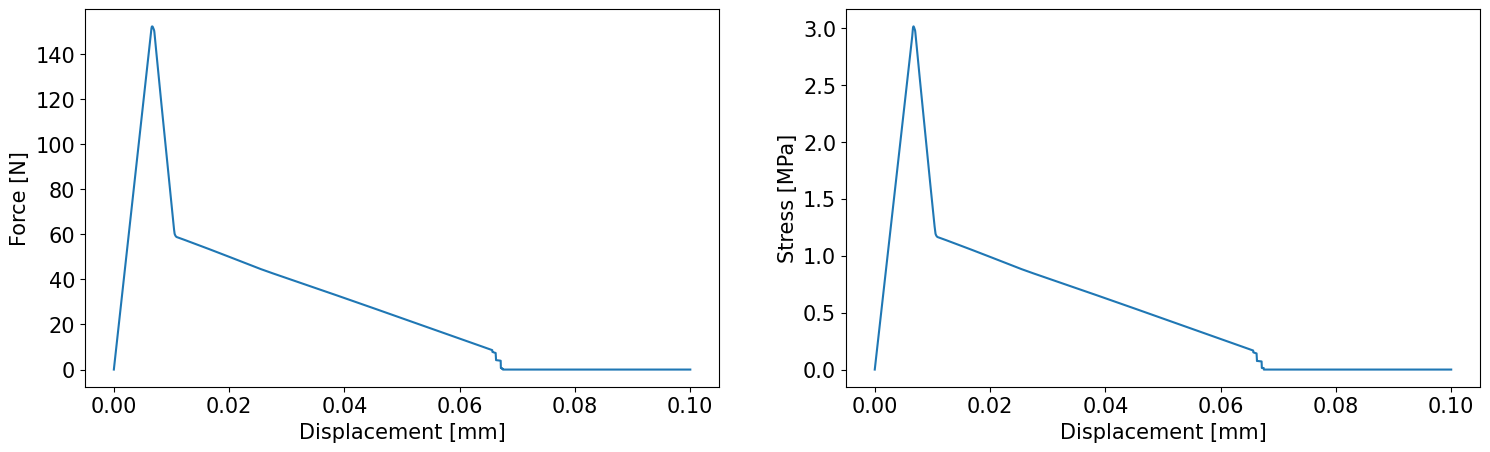

In [ ]:
# plot force-displacement and stress-displacement curves recorded at the top of the specimen
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
plt.rcParams.update({'font.size': 15})
axes[0].plot(disp, RF, "-")
axes[0].set(xlabel='Displacement [mm]', ylabel='Force [N]');
axes[1].plot(disp, sigy, "-")
axes[1].set(xlabel='Displacement [mm]', ylabel='Stress [MPa]');

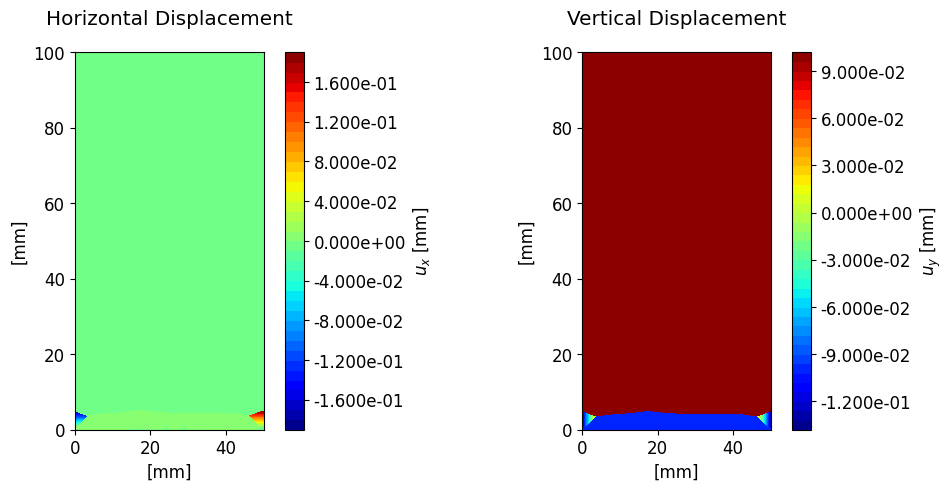

In [ ]:
# plot displacement fields
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.rcParams.update({'font.size': 12})
tc = tricontourf(u.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$u_x$ [mm]', format='%.3e')
axes[0].set_title('Horizontal Displacement', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[mm]', ylabel='[mm]');
tc = tricontourf(u.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$u_y$ [mm]', format='%.3e')
axes[1].set_title('Vertical Displacement', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[mm]', ylabel='[mm]');

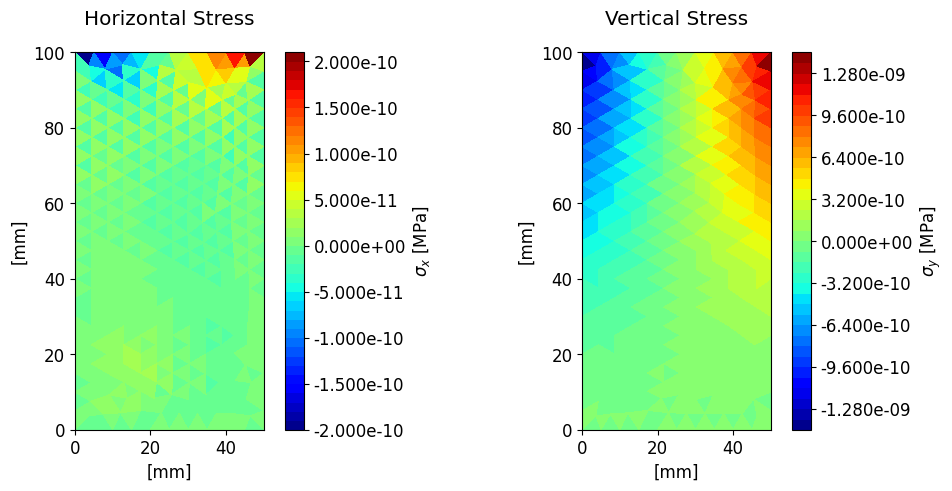

In [ ]:
# plot stress fields
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.rcParams.update({'font.size': 12})
tc = tricontourf(sig.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$\sigma_x$ [MPa]', format='%.3e')
axes[0].set_title('Horizontal Stress', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[mm]', ylabel='[mm]');
tc = tricontourf(sig.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$\sigma_y$ [MPa]', format='%.3e')
axes[1].set_title('Vertical Stress', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[mm]', ylabel='[mm]');

In [ ]:
# obtain defromed mesh
displaced_coordinates = interpolate(SpatialCoordinate(mesh)+u, V)
displaced_mesh = Mesh(displaced_coordinates)

# extract joint information
x, y = SpatialCoordinate(mesh)
V1s_f = VectorFunctionSpace(mesh, "HDiv Trace", 1)
S1s_f = FunctionSpace(mesh, "HDiv Trace", 1)

ficx, ficy = Function(S1s_f).interpolate(x).dat.data, Function(S1s_f).interpolate(y).dat.data
fic1 = np.vstack([ficx,ficy]).T
fic = np.concatenate([fic1,fic1])
fcd1 = Function(V1s_f).assign(facet_project(avg(u), V1s_f)).dat.data+0.5*Function(V1s_f).assign(facet_project(jump(u), V1s_f)).dat.data
fcdj = Function(V1s_f).assign(facet_project(avg(u), V1s_f)).dat.data-0.5*Function(V1s_f).assign(facet_project(jump(u), V1s_f)).dat.data
fcd = np.concatenate([fcd1,fcdj])
fcc = fic+fcd

number_of_nodes = fcc.shape[0]
number_of_joints = number_of_nodes // 2
joint_connectivity = np.arange(0,number_of_nodes).reshape(number_of_joints,2)
all_joint_state = np.concatenate([flag.dat.data, flag.dat.data])

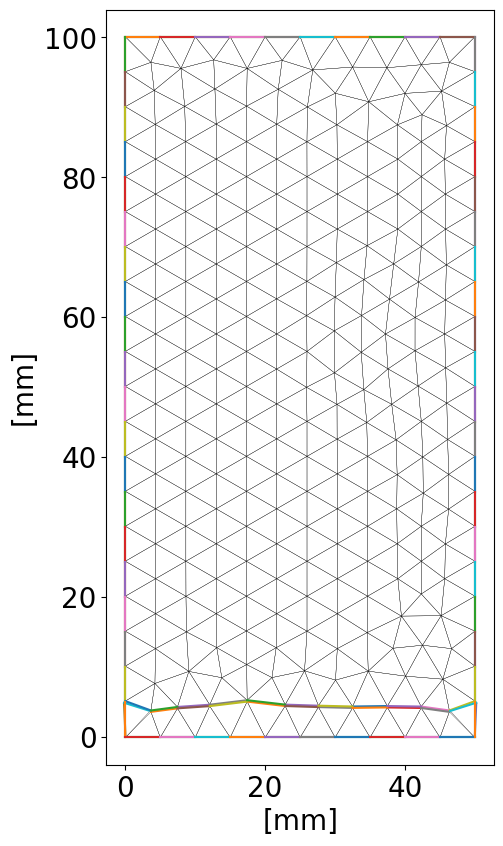

In [ ]:
# plot the crack path (failed joint elements) superimposed on deformed mesh
fig, axes = plt.subplots(figsize=(5, 10), dpi=100)
triplot(displaced_mesh, axes=axes, interior_kw={'linewidth': 0.2})
axes.set_aspect("equal")
axes.set(xlabel='[mm]', ylabel='[mm]');

for i, joint in enumerate(joint_connectivity):
    if all_joint_state[i] == 0:
        plt.plot(fcc[:,0][joint], fcc[:,1][joint])
plt.axis('equal');
plt.rcParams.update({'font.size': 20})

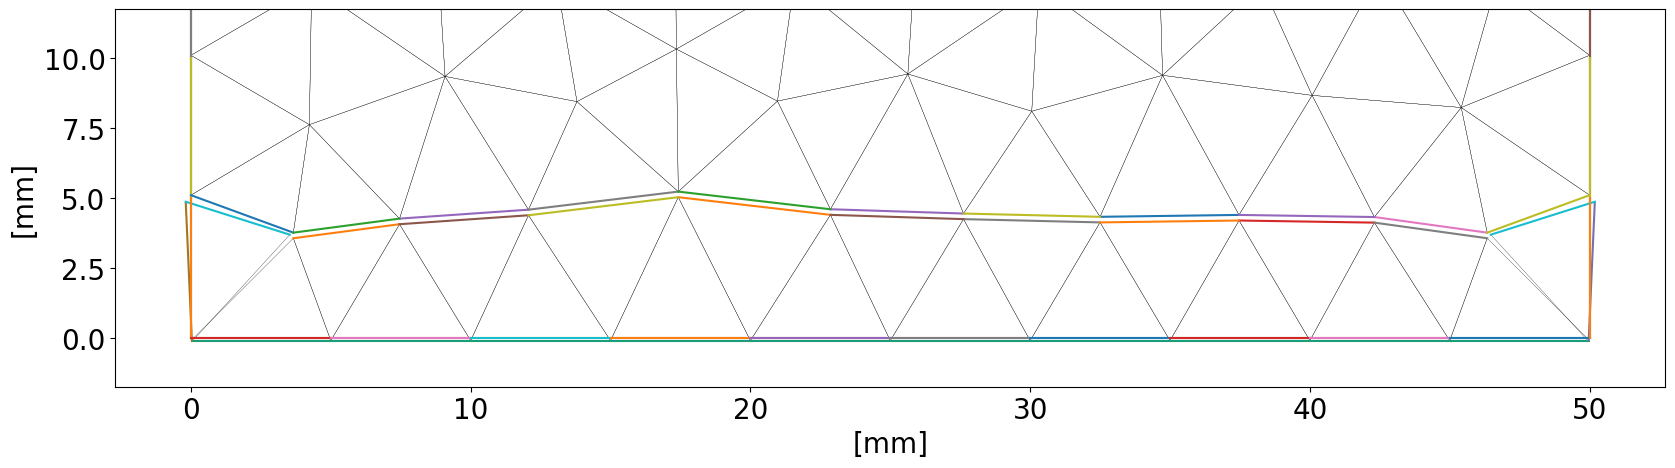

In [ ]:
# plot close-up view of the crack path
fig, axes = plt.subplots(figsize=(20, 5), dpi=100)
triplot(displaced_mesh, axes=axes, interior_kw={'linewidth': 0.2})
axes.set_aspect("equal")
axes.set(xlabel='[mm]', ylabel='[mm]');

for i, joint in enumerate(joint_connectivity):
    if all_joint_state[i] == 0:
        plt.plot(fcc[:,0][joint], fcc[:,1][joint])
plt.axis('equal');
plt.rcParams.update({'font.size': 20})
axes.set_ylim([0, 10]);